In [40]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [42]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [43]:
import pickle
import torch
import numpy as np
import torchvision
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
from torch.utils.data import Dataset, DataLoader  # Gives easier dataset managment and creates mini batches
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard
import pickle  # for importing dataset from pickle file
import matplotlib.pyplot as plt
import datetime
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torch.nn.functional as F

# Importing the required dataset

In [44]:
pickle_in = open("/content/drive/MyDrive/Colab Notebooks/pytorch/minor project/minor Project as handwritten classification/X_desired_shape_resize_64_10000_each_class.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("/content/drive/MyDrive/Colab Notebooks/pytorch/minor project/minor Project as handwritten classification/y_desired_shape_resize_64_10000_each_class.pickle","rb")
y = pickle.load(pickle_in)

In [45]:
# list to numpy conversion
y = np.array(y)
# X = X.reshape(460000,64,64)
# numpy array
print(X.shape)
print(y.shape)

print(type(X))
# list
print(type(y))


(460000, 1, 64, 64)
(460000,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [46]:
X = list(X)
y = list(y)

# print(X.shape)
# print(y.shape)
print(type(X))
print(type(y))

<class 'list'>
<class 'list'>


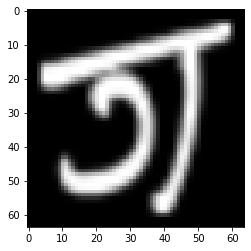

In [47]:
plt.imshow(X[20000][0], cmap="gray")

In [48]:
X[0].shape

(1, 64, 64)

In [49]:
class Nepali_Dataset(Dataset):
  def __init__(self, image, label):
    self.x = image
    self.y = label
    self.n_samples = np.array(y).shape[0]

  def __getitem__(self, index):
    return self.x[index], self.y[index]

  def __len__(self):
    return self.n_samples
  



In [50]:
dataset = Nepali_Dataset(X, y)



In [51]:
val_size = 92000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(368000, 92000)

In [52]:
print(train_ds)

In [53]:
batch_size=128


In [54]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2)
val_dl = DataLoader(val_ds, batch_size*2, shuffle=True, num_workers=2)

In [55]:
def show_batch(dl):
    for images, labels in dl:
        print(images,labels)
        print("======================================================")
        print("shape == ",images.shape,labels.shape)
        print("======================================================")

        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        ...,


        [[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]],


        [[[0, 0, 0,  ..., 0, 0, 0],
         

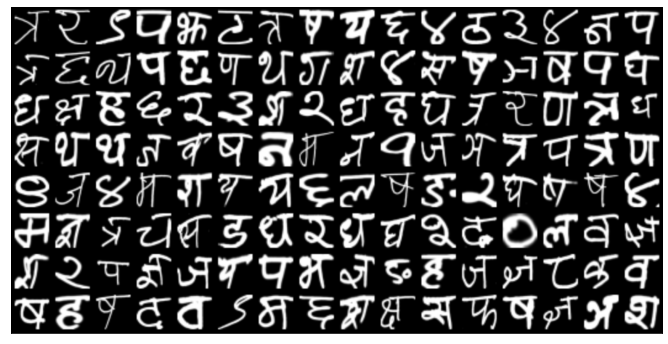

In [56]:
show_batch(train_dl)

# **Model creation**

In [57]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [58]:
class NepaliLetterModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 32 x 32

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 8 x 8

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 512 x 4 x 4


            nn.Flatten(), 
            nn.Linear(512*4*4, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 46))
        
    def forward(self, xb):
        return self.network(xb.float())

In [59]:
model = NepaliLetterModel()
model

NepaliLetterModel(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(512, 512, kernel_size=(3, 3), strid

In [60]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images.float())
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 1, 64, 64])
out.shape: torch.Size([128, 46])
out[0]: tensor([-0.0207,  0.0291,  0.0315,  0.0390,  0.0539, -0.0007, -0.0278, -0.0407,
         0.0292,  0.0232, -0.0087, -0.0364, -0.0405,  0.0355, -0.0433,  0.0184,
        -0.0415,  0.0283,  0.0396,  0.0024, -0.0553,  0.0399, -0.0087, -0.0049,
         0.0008,  0.0079, -0.0247,  0.0452,  0.0485,  0.0071, -0.0303, -0.0110,
         0.0251,  0.0420,  0.0522, -0.0222,  0.0005,  0.0022, -0.0014, -0.0453,
        -0.0492,  0.0301, -0.0224, -0.0118, -0.0358,  0.0334],
       grad_fn=<SelectBackward>)


In [61]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [62]:
device = get_default_device()
device

device(type='cuda')

In [63]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

# **Training the Model**

In [64]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [65]:
model = to_device(NepaliLetterModel(), device)

In [66]:
evaluate(model, val_dl)


{'val_acc': 0.026153789833188057, 'val_loss': 3.829090118408203}

In [67]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
plot_accuracies(history)


In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

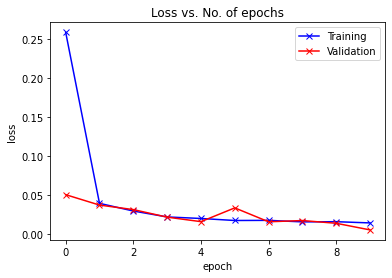

In [39]:
plot_losses(history)

# **Testing with individual images**

# **Saving and loading the model**

In [ ]:
torch.save(model.state_dict(), 'nepali_cnn.pth')